<a href="https://colab.research.google.com/github/aleksiheikkila/Colorectal_histology_image_classification/blob/master/Colorectal_histology_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multiclass image classification problem using colorectal histology images.

## Data
Sourced from Kaggle: https://www.kaggle.com/kmader/colorectal-histology-mnist

This data set represents a collection of textures in histological images of human colorectal cancer. It contains two files:

* "Kather_texture_2016_image_tiles_5000.zip": a zipped folder containing 5000 histological images of 150 * 150 px each (74 * 74 µm). Each image belongs to exactly one of eight tissue categories (specified by the folder name). 
* "Kather_texture_2016_larger_images_10.zip": a zipped folder containing 10 larger histological images of 5000 x 5000 px each. These images contain more than one tissue type. Image format

All images are RGB, 0.495 µm per pixel, digitized with an Aperio ScanScope (Aperio/Leica biosystems), magnification 20x.


## Setup

Run on Google Colab. The beginning of the notebook contains some Colab specific setup stuff such as integrating with Google Drive (primarily to persistenty store the trained models)

Data was sourced from Kaggle: https://www.kaggle.com/kmader/colorectal-histology-mnist. This was done thru the Kaggle Api (API credentials needed). The compressed size of the data is something around 1 GB.

For the deep learning I used fastai v1 CNN with pretrained (imagenet) resnet50 architecture.


In [118]:
import os
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'kaggle/Colorectal_histology'


models_dir = base_dir + "/saved_models"

if not os.path.exists(models_dir):
  os.makedirs(models_dir)

Mounted at /content/gdrive


In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.5)


In [0]:
! mkdir -p ~/.kaggle/
!cp "gdrive/My Drive/fastai-v3/kaggle.json" ~/.kaggle/

In [7]:
# About 1 GB worth of data to download
!kaggle datasets download -d kmader/colorectal-histology-mnist

 99% 981M/991M [00:10<00:00, 126MB/s]
100% 991M/991M [00:10<00:00, 95.6MB/s]


In [8]:
!pwd
!ls -la

/content
total 1014732
drwxr-xr-x 1 root root       4096 Sep  8 18:53 .
drwxr-xr-x 1 root root       4096 Sep  8 18:50 ..
-rw-r--r-- 1 root root 1039060260 Sep  8 18:53 colorectal-histology-mnist.zip
drwxr-xr-x 1 root root       4096 Sep  4 16:06 .config
lrwxrwxrwx 1 root root         18 Sep  8 18:53 data -> /root/.fastai/data
drwx------ 3 root root       4096 Sep  8 18:53 gdrive
lrwxrwxrwx 1 root root         19 Sep  8 18:53 models -> /root/.torch/models


In [9]:
path = Config.data_path()/'colon'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/colon')

In [10]:
!ls -la "data/colon/"

total 8
drwxr-xr-x 2 root root 4096 Sep  8 18:53 .
drwxr-xr-x 3 root root 4096 Sep  8 18:53 ..


In [0]:
!unzip -q -n colorectal-histology-mnist.zip -d {path}

In [12]:
!ls {path}


hmnist_28_28_L.csv    hmnist_8_8_RGB.csv
hmnist_28_28_RGB.csv  Kather_texture_2016_image_tiles_5000.zip
hmnist_64_64_L.csv    Kather_texture_2016_larger_images_10.zip
hmnist_8_8_L.csv


In [0]:
!unzip -q -n {path}/Kather_texture_2016_image_tiles_5000.zip -d {path}
!unzip -q -n {path}/Kather_texture_2016_larger_images_10.zip -d {path}

In [0]:
# remove zips

In [15]:
(path/"Kather_texture_2016_image_tiles_5000").ls()

[PosixPath('/root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000/01_TUMOR'),
 PosixPath('/root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000/02_STROMA'),
 PosixPath('/root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000/06_MUCOSA'),
 PosixPath('/root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000/07_ADIPOSE'),
 PosixPath('/root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000/03_COMPLEX'),
 PosixPath('/root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000/04_LYMPHO'),
 PosixPath('/root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000/05_DEBRIS'),
 PosixPath('/root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000/08_EMPTY')]

In [0]:
# Mapping dictionaries
class_names = {1: "Tumor", 2: "Stroma", 3: "Complex", 4: "Lympho", 5: "Debris", 6: "Mucosa", 7: "Adipose", 8: "Empty"}

class_numbers = {"Tumor": 1, "Stroma": 2, "Complex": 3, "Lympho": 4, "Debris": 5, "Mucosa": 6, "Adipose": 7, "Empty": 8}

In [0]:
#(path/"Kather_texture_2016_image_tiles_5000"/"01_TUMOR").ls()

The dataset is organized into...



In [0]:
# CHECK IMAGE SIZES
import glob
import numpy as np

from PIL import Image


def get_img_size(filepath):
    """returns width, height in px tuple"""
    img = Image.open(filepath) 
    width, height = img.size
    try:
      num_channels = np.array(img).shape[2]
    except IndexError:
      num_channels = 1

    return width, height, num_channels


In [19]:

image_files = [f for f in (path/"Kather_texture_2016_image_tiles_5000"/"01_TUMOR").glob("*.tif")]
print(len(image_files))

625


In [20]:
sizes = [get_img_size(img_fn) for img_fn in image_files[:1000]]
sizes_by_dim = [channel for channel in zip(*sizes)]

list(map(np.mean, sizes_by_dim))

#  all 150 by 150, 3 channels (RGB)

[150.0, 150.0, 3.0]

In [0]:
#sizes_by_dim[0]

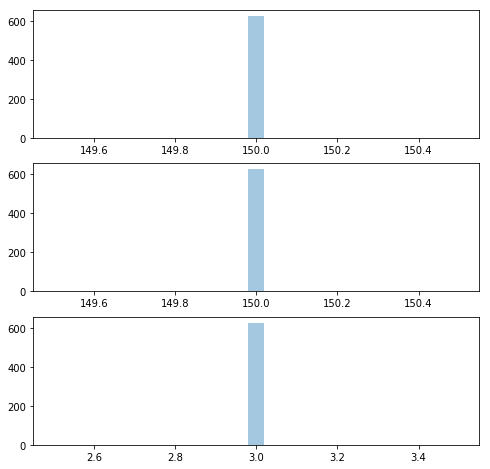

In [22]:
# Images sizes from a sample
# grayscale, 1 channel

import matplotlib.pyplot as plt
import seaborn as sns


f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))

sns.distplot(sizes_by_dim[0], kde=False, ax=ax1)
sns.distplot(sizes_by_dim[1], kde=False, ax=ax2)
sns.distplot(sizes_by_dim[2], kde=False, ax=ax3)

The dataset also contains csv files apparently containing flattened pixel values of the images downsized to e.g. 28x28 (a couple of different variants), alongside with the correct label. Read one in

In [23]:
df = pd.read_csv(path/"hmnist_28_28_RGB.csv")  
print(df.shape)  # 28x28x3
df.sample(3)

(5000, 2353)


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
1450,221,201,214,223,210,220,228,217,226,228,216,226,226,215,226,228,217,229,228,216,229,223,210,224,224,216,227,237,234,241,242,241,246,242,239,243,241,238,243,241,...,240,240,243,241,240,244,241,238,245,241,238,244,240,239,242,239,237,239,241,239,239,240,240,237,240,239,239,243,241,244,242,240,244,242,238,247,241,240,244,7
2498,165,135,175,157,126,168,133,106,152,121,76,128,120,71,123,106,56,108,167,131,168,173,141,178,174,131,175,183,148,188,186,148,188,120,71,126,110,53,102,124,...,154,121,163,137,94,147,159,117,165,147,104,155,137,77,127,153,103,145,174,140,174,187,155,184,128,86,131,110,58,110,140,95,145,148,106,151,144,105,147,6
1340,239,238,236,198,163,186,206,177,197,228,213,221,239,233,238,245,242,243,245,238,240,246,245,244,250,250,246,254,248,247,232,221,222,189,156,171,175,125,155,204,...,242,242,240,242,242,240,242,242,240,242,243,238,242,243,238,242,243,238,242,243,238,242,243,238,242,243,238,242,243,238,242,243,238,242,243,238,241,244,239,7


Text(0.5, 0, 'Target label')

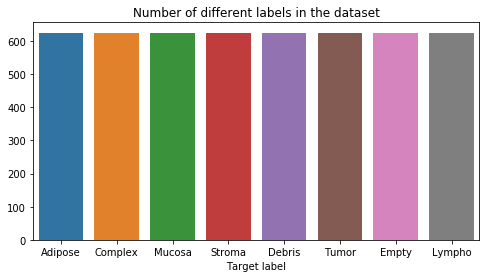

In [24]:
label_counts = df["label"].value_counts()
x_classes = [class_names[idx] for idx in label_counts.index]

plt.figure(figsize=(8,4))
sns.barplot(x=x_classes, y=label_counts.values)
plt.title("Number of different labels in the dataset")
plt.xlabel("Target label")

In [46]:
doc(ImageList)

In [0]:
np.random.seed(42)

# ImageList or ImageItemList
src = (ImageList.from_folder(path=path/"Kather_texture_2016_image_tiles_5000")
       .split_by_rand_pct(valid_pct=0.2, seed=42)
       .label_from_folder())  # split the multiple labels



In [0]:
tfms = get_transforms(flip_vert=True, max_warp=0.)

In [0]:
data = (src.transform(tfms, size=150)
        .databunch(bs=64).normalize(imagenet_stats))

# always use the normalization stats that were used to train the model

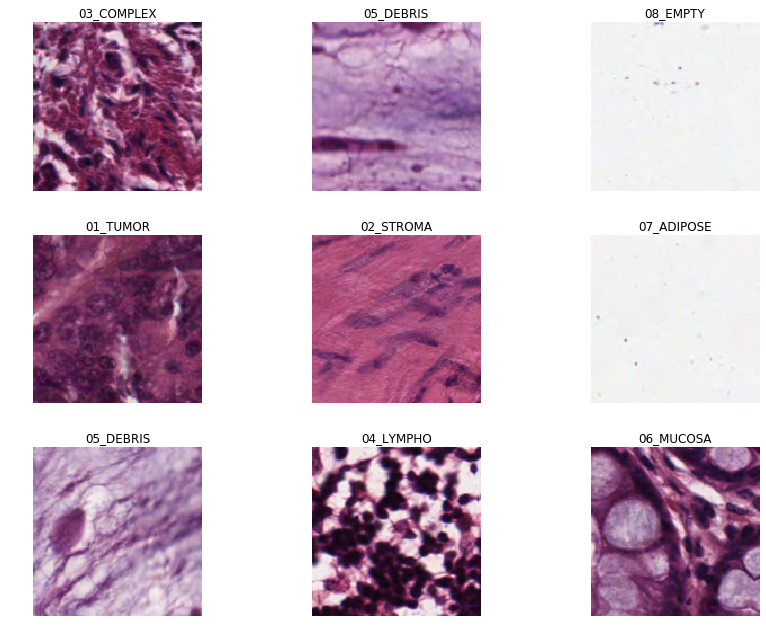

In [50]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [29]:
learn = cnn_learner(data, arch, metrics=accuracy, path=base_dir, model_dir=models_dir)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 19208543.10it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


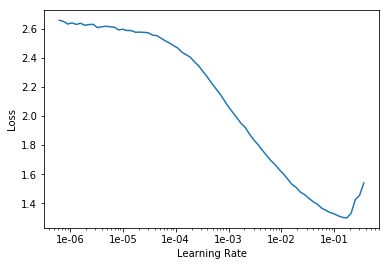

In [53]:
learn.lr_find()
learn.recorder.plot()

In [55]:
lr = 1e-3
learn.fit_one_cycle(10, slice(lr))  #

epoch,train_loss,valid_loss,accuracy,time
0,0.468961,0.318726,0.886000,00:37
1,0.415256,0.281234,0.896000,00:37
2,0.368600,0.272240,0.897000,00:37
3,0.349322,0.237473,0.915000,00:37
4,0.305132,0.229071,0.920000,00:37
5,0.279297,0.211422,0.922000,00:37
6,0.242178,0.197021,0.930000,00:37
7,0.225307,0.187460,0.934000,00:37
8,0.219537,0.188346,0.940000,00:37
9,0.200905,0.184403,0.939000,00:37


In [0]:
#learn.save(os.path.join(models_dir, 'stage-1-rn50'))
learn.save('stage-1-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


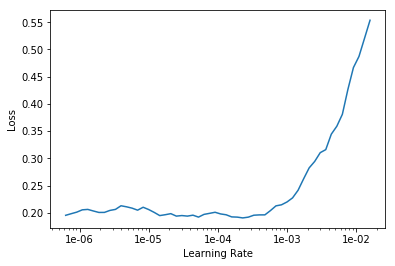

In [57]:
# Fine tune whole model
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [61]:
# Fitted something like 15 cycles
learn.fit_one_cycle(3, slice(7e-6, 2e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.045636,0.114831,0.962000,00:49
1,0.056342,0.127303,0.963000,00:49
2,0.050303,0.117599,0.966000,00:49


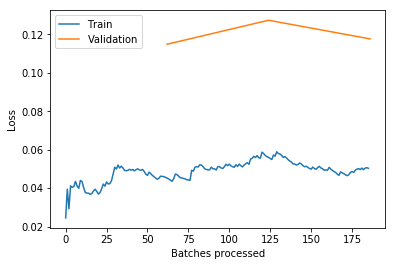

In [62]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-rn50')

In [30]:
learn.load('stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (4000 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
01_TUMOR,01_TUMOR,01_TUMOR,01_TUMOR,01_TUMOR
Path: /root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
06_MUCOSA,03_COMPLEX,03_COMPLEX,02_STROMA,02_STROMA
Path: /root/.fastai/data/colon/Kather_texture_2016_image_tiles_5000;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_s

## Interpretation

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

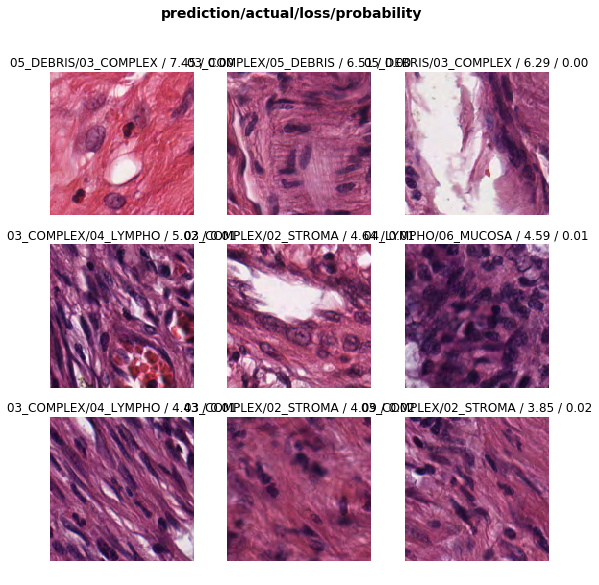

In [65]:
interp.plot_top_losses(9, figsize=(9,9))

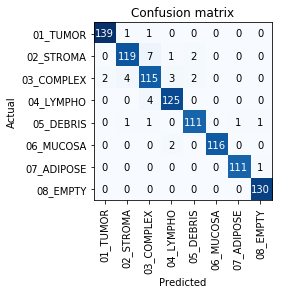

In [66]:
interp.plot_confusion_matrix()

In [67]:
interp.most_confused()

[('02_STROMA', '03_COMPLEX', 7),
 ('03_COMPLEX', '02_STROMA', 4),
 ('04_LYMPHO', '03_COMPLEX', 4),
 ('03_COMPLEX', '04_LYMPHO', 3),
 ('02_STROMA', '05_DEBRIS', 2),
 ('03_COMPLEX', '01_TUMOR', 2),
 ('03_COMPLEX', '05_DEBRIS', 2),
 ('06_MUCOSA', '04_LYMPHO', 2),
 ('01_TUMOR', '02_STROMA', 1),
 ('01_TUMOR', '03_COMPLEX', 1),
 ('02_STROMA', '04_LYMPHO', 1),
 ('05_DEBRIS', '02_STROMA', 1),
 ('05_DEBRIS', '03_COMPLEX', 1),
 ('05_DEBRIS', '07_ADIPOSE', 1),
 ('05_DEBRIS', '08_EMPTY', 1),
 ('07_ADIPOSE', '08_EMPTY', 1)]

## Predict a single image

Prediction:
 (Category 01_TUMOR, tensor(0), tensor([9.9999e-01, 4.5945e-08, 2.7442e-07, 6.9594e-06, 1.8411e-08, 2.2547e-06,
        2.0760e-07, 3.4232e-07]))

The ground truth label: 01_TUMOR


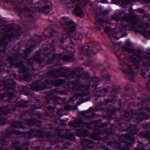

In [34]:
img = learn.data.train_ds[0][0]


print("Prediction:\n", learn.predict(img))
print("\nThe ground truth label:", learn.data.train_ds[0][1])
img

## Heatmap to show the "most activated regions" (i.e. kind of where the model is paying attention to)

In [0]:
m = learn.model.eval()
# Sets the module in evaluation mode.
# This has any effect only on certain modules.


Category 01_TUMOR

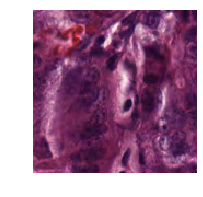

In [113]:
# Grab one sample image based on idx
idx=6

x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [114]:
xb, _ = data.one_item(x)  # create a minibatch of one

#xb_im = Image(data.denorm(xb)[0])  # denormalize
#print(data.denorm(xb)[0].numpy().shape)
xb_im_np = data.denorm(xb)[0].numpy()
xb_im_np = np.swapaxes(xb_im_np, 0, 2)
print(xb_im_np.shape)

xb_im = Image.fromarray(xb_im_np, "RGB")  # denormalize.
xb = xb.cuda()  # put to GPU

xb_im.show()

(150, 150, 3)


In [0]:
from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a, hook_g

In [0]:
hook_a, hook_g = hooked_backward()

acts  = hook_a.stored[0].cpu()
#acts.shape

avg_acts = acts.mean(0)
#avg_acts.shape
#avg_acts

def show_heatmap(hm):
    _, ax = plt.subplots(figsize=(7,7))
    #xb_im.show(ax)
    x.show(ax)  # use the original instead
    ax.imshow(hm, alpha=0.6, extent=(0,150,150,0), interpolation='bilinear', cmap='magma');
    
    #interpolate the (5x5) heatmap to the size of the whole histology image (which were 150x150)
    
    
    

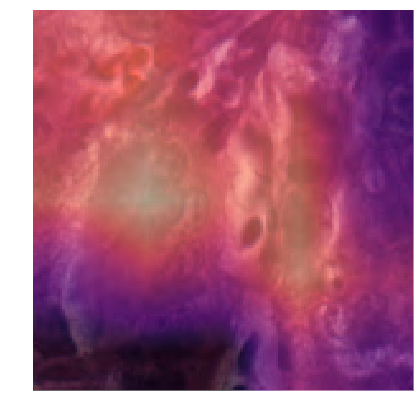

In [117]:
show_heatmap(avg_acts)